# Exp 2
### Description


In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt

print('Tensorflow version ', tf.__version__)

tf.test.is_built_with_gpu_support()

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

#plt.gray()

Tensorflow version  2.4.1


False

In [2]:
IM_WIDTH = 128
IM_HEIGHT = 128
IM_CH = 1
BATCH_SIZE = 4
POV = 180

In [3]:
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
import numpy as np
import math
from tensorflow.keras.layers import Add, Activation, Dense, Conv2D, MaxPooling2D, UpSampling2D, Embedding, Concatenate, Lambda, Conv2DTranspose, Reshape, Flatten, BatchNormalization, Dropout
from tensorflow.keras import Model, Input
from tensorflow_addons.layers import InstanceNormalization
#from layers import CoordinateChannel2D, AdaIN

l_relu = tf.nn.relu

def residual(layer_input, filters):
    shortcut = layer_input
    y = Conv2D(filters, (3,3), strides=1, padding='same')(layer_input)
    y = InstanceNormalization(axis=-1, center=False, scale=False)(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, (3,3), strides=1, padding='same')(y)
    y = InstanceNormalization(axis=-1, center=False, scale=False)(y)
    
    return Add()([shortcut, y])

def resize_like_shape(inputs, ref):
    i_h, i_w = inputs.get_shape()[1], inputs.get_shape()[2]
    r_h, r_w = ref[0], ref[1]
    if i_h == r_h and i_w == r_w:
        return inputs
    else:
        # TODO(casser): Other interpolation methods could be explored here.
        return tf.image.resize(inputs, [r_h, r_w], method=tf.image.ResizeMethod.BILINEAR)

def resize_like(inputs, ref):
    i_h, i_w = inputs.get_shape()[1], inputs.get_shape()[2]
    r_h, r_w = ref.get_shape()[1], ref.get_shape()[2]
    if i_h == r_h and i_w == r_w:
        return inputs
    else:
        # TODO(casser): Other interpolation methods could be explored here.
        return tf.image.resize(inputs, [r_h, r_w], method=tf.image.ResizeMethod.BILINEAR)

def ups(layer_input, filters):
    shortcut = layer_input
    b, h, w, c = layer_input.shape
    y = Lambda(lambda x: tf.image.resize(x, [h*2, w*2], method=tf.image.ResizeMethod.BILINEAR))(layer_input)
    y = Conv2D(filters, (3,3), strides=1, activation=l_relu, padding='same')(y)
    
    return y
    
def feature_model(input_shape):
    input_img = Input(shape=input_shape, name='feature_model_input')
    
    conv_1 = Conv2D(32, (3, 3), strides=1, activation=l_relu, padding='same')(input_img)
    res_1 = residual(conv_1, 32)
    res_2 = residual(res_1, 32)
    res_3 = residual(res_2, 32)
    conv_2 = Conv2D(64, (3, 3), strides=1, activation=l_relu, padding='same')(res_3)
    res_4 = residual(conv_2, 64)
    res_5 = residual(res_4, 64)
    res_6 = residual(res_5, 64)
    res_7 = residual(res_6, 64)
    res_8 = residual(res_7, 64)
    #conv_2 = Conv2D(128, (3, 3), strides=1, activation=l_relu, padding='same')(res_3)

    return Model(input_img, res_8, name='Feature net')

def refinement_model(input_shape, output_shape):
    input_img = Input(shape=input_shape, name='refinement_model_input')
    
    #conv_1 = Conv2D(64, (3, 3), strides=1, activation=l_relu, padding='same')(input_img)
    res_1 = residual(input_img, 64)
    conv_1 = Conv2D(128, (3, 3), strides=1, activation=l_relu, padding='same')(res_1)
    res_2 = residual(conv_1, 128)
    conv_2 = Conv2D(256, (3, 3), strides=2, activation=l_relu, padding='same')(res_2)
    res_3 = residual(conv_2, 256)
    conv_2_2 = Conv2D(256, (3, 3), strides=2, activation=l_relu, padding='same')(res_3)
    res_4 = residual(conv_2_2, 256)
    conv_3 = Conv2D(128, (3, 3), strides=1, activation=l_relu, padding='same')(res_4)
    res_5 = residual(conv_3, 128)
    conv_3_2 = Conv2DTranspose(128, (3, 3), strides=2, activation=l_relu, padding='same')(res_5)
    res_6 = residual(conv_3_2, 128)
    conv_3_3 = Conv2DTranspose(128, (3, 3), strides=2, activation=l_relu, padding='same')(res_6)
    res_7 = residual(conv_3_3, 128)
    conv_4 = Conv2D(output_shape[-1], (3, 3), strides=1, activation=l_relu, padding='same')(res_7)
    res_8 = residual(conv_4, output_shape[-1])
    conv_5 = Conv2D(output_shape[-1], (3, 3), strides=1, activation='sigmoid', padding='same')(res_8)
    #conv_2 = Conv2D(output_shape[-1], (3, 3), strides=1, activation='sigmoid', padding='same')(conv_1)

    return Model(input_img, conv_5, name='Refinement net')

def encoder_model(input_shape):
    input_img = Input(shape=input_shape, name='encoder_input')
    conv_1 = Conv2D(32, (3, 3), strides=2, activation=l_relu, padding='same', name='conv_1')(input_img)
    conv_1_smooth = Conv2D(32, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_1_smooth')(conv_1)
    conv_2 = Conv2D(64, (3, 3), strides=2, activation=l_relu, padding='same', name='conv_2')(conv_1_smooth)
    conv_2_smooth = Conv2D(64, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_2_smooth')(conv_2)
    conv_3 = Conv2D(128, (3, 3), strides=2, activation=l_relu, padding='same', name='conv_3')(conv_2_smooth)
    conv_3_smooth = Conv2D(128, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_3_smooth')(conv_3)
    conv_4 = Conv2D(256, (3, 3), strides=2, activation=l_relu, padding='same', name='conv_4')(conv_3_smooth)
    conv_4_smooth = Conv2D(256, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_4_smooth')(conv_4)
    encoder_output = conv_4_smooth

    return Model(input_img, [encoder_output,conv_4_smooth,conv_3_smooth,conv_2_smooth,conv_1_smooth], name='Encoder')

def slice_model(input_shape, output_shape, enc_model):
    input_img = Input(shape=input_shape)

    _, bottleneck, conv_3, conv_2, conv_1  = enc_model(input_img)
    
    np_output_shape = (np.array(output_shape) // math.pow(2,4)).astype(np.int64)
    
    bottleneck = Lambda(lambda x: resize_like_shape(x[0],x[1]), name='resized_conv_3')([
        bottleneck, [np_output_shape[0], np_output_shape[1], 256]
    ])
    
#     bottleneck = Flatten()(bottleneck)
#     bottleneck = Dense(256*np_output_shape[0]*np_output_shape[1], activation=l_relu)(bottleneck)
#     print(bottleneck.shape)
#     bottleneck = Reshape([np_output_shape[0], np_output_shape[1], 256])(bottleneck)
#     print(bottleneck.shape)

    deconv_4 = Conv2DTranspose(256, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_4')(bottleneck)
    resized_conv_3 = Lambda(lambda x: resize_like(x[0],x[1]), name='resized_conv_3')([conv_3, deconv_4])
    concat_4 = Concatenate(axis=-1, name='concat_4')([deconv_4, resized_conv_3])
    conv_concat_4 = Conv2D(256, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_4')(concat_4)

    deconv_3 = Conv2DTranspose(128, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_3')(conv_concat_4)
    resized_conv_2 = Lambda(lambda x: resize_like(x[0],x[1]), name='resized_conv_2')([conv_2, deconv_3])
    concat_3 = Concatenate(axis=-1, name='concat_3')([deconv_3, resized_conv_2])
    conv_concat_3 = Conv2D(128, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_3')(concat_3)

    deconv_2 = Conv2DTranspose(64, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_2')(conv_concat_3)
    resized_conv_1 = Lambda(lambda x: resize_like(x[0],x[1]), name='resized_conv_1')([conv_1, deconv_2])
    concat_2 = Concatenate(axis=-1, name='concat_2')([deconv_2, resized_conv_1])
    conv_concat_2 = Conv2D(64, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_2')(concat_2)
    #slice_2 = Conv2D(1, 3, strides=1, activation='sigmoid', padding='same', name='slice_2')(conv_concat_2)

    deconv_1 = Conv2DTranspose(32, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_1')(conv_concat_2)
    #slice_resized_2 = Lambda(lambda x: resize_like(x[0],x[1]), name='slice_resized_2')([slice_2, deconv_1])
    #concat_1 = Concatenate(axis=-1, name='concat_1')([deconv_1, slice_resized_2])
    conv_concat_1 = Conv2D(32, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_1')(deconv_1)
    slice_1 = Conv2D(1, 3, strides=1, activation='sigmoid', padding='same', name='slice_1')(conv_concat_1)

    return Model(input_img, [slice_1,slice_1], name='slice_net')

def ego_model(encoder, name='ego_model'):
    encoders_shape = encoder.output[0].shape
    encoders_shape = encoders_shape[1:-1] + encoders_shape[-1]*2

    ego_input = tf.keras.Input(shape=encoders_shape)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same', name='ego_1')(ego_input)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same', name='ego_2')(x)
    x = Conv2D(6, (1, 1), padding='same')(x)
    x = Lambda(lambda x: tf.reduce_mean(x, [1,2]))(x)
    ego_output = Lambda(lambda x: tf.reshape(x, [-1, 1, 6]), name='ego_output')(x)
    ego_output_scaled = Lambda(lambda x: tf.concat([x[:, 0:3]*0.001,x[:, 3:6]*0.01], axis=1), name='ego_output_scaled')(ego_output)
    ego_net = tf.keras.Model(ego_input,ego_output_scaled, name=name)
    return ego_net

# def discriminator_realfake(img_shape, output_shape):
#     input_img = Input(shape=img_shape, name='discriminator_input')
#     x = Conv2D(8, (3, 3), strides=2, activation=l_relu, padding='same')(input_img)
#     x = Conv2D(16, (3, 3), strides=2, activation=l_relu, padding='same')(x)
#     x = Conv2D(32, (3, 3), strides=2, activation=l_relu, padding='same')(x)
#     #x = Conv2D(64, (3, 3), strides=2, activation=l_relu, padding='same')(x)
#     x = Flatten()(x)
#     x = Dense(64, activation=l_relu)(x)
#     x = Dense(output_shape, activation='sigmoid')(x)
#     return Model(input_img, x)

# def discriminator_angle(img_shape, output_shape):
#     input_img = Input(shape=img_shape, name='discriminator_input')
#     x = Conv2D(8, (3, 3), strides=2, activation=l_relu, padding='same')(input_img)
#     x = Conv2D(16, (3, 3), strides=2, activation=l_relu, padding='same')(x)
#     x = Conv2D(32, (3, 3), strides=2, activation=l_relu, padding='same')(x)
#     #x = Conv2D(64, (3, 3), strides=2, activation=l_relu, padding='same')(x)
#     x = Flatten()(x)
#     x = Dense(64, activation=l_relu)(x)
#     x = Dense(output_shape, activation='tanh')(x)
#     return Model(input_img, x)

#encoder_sino = encoder_model((POV, IM_WIDTH, IM_CH))
#feature_net = feature_model(img_shape)
#slice_net = slice_model((POV, IM_WIDTH, IM_CH), (IM_WIDTH, IM_HEIGHT, IM_CH), encoder_sino)
#graddecoder = depth_model(IM_HEIGHT, IM_WIDTH, encoder, name='grad_decoder')
#ego_net = ego_model(encoder_depth)

#refinement_input = (IM_WIDTH, IM_HEIGHT, feature_net.output.shape[-1])
#encoder_refinement = encoder_model(refinement_input)
#print(refinement_input)
#refinement_net = refinement_model(refinement_input, img_shape)

# model_input1 = tf.keras.Input(shape=img_shape, name='input_frame_1')
# model_input2 = tf.keras.Input(shape=img_shape, name='input_frame_2')
# model_input_intrinsics = tf.keras.Input(shape=(3,3,3), name='input_intrinsics')
# model_layer_intrinsics_inv = tf.keras.layers.Lambda(lambda x: tf.linalg.inv(x))(model_input_intrinsics)

# encd1 = encoder(model_input1)
# encd2 = encoder(model_input2)

# depth1 = decoder(model_input1)
# depth2 = decoder(model_input2)

# stereopair = tf.keras.layers.Concatenate()([encd1[0],encd2[0]])
# ego = ego_net(stereopair)

# my_model = tf.keras.Model(
#     [model_input1, 
#      model_input2, 
#      model_input_intrinsics
#     ],
#     [depth1,
#      depth2,
#      ego,
#      model_layer_intrinsics_inv
#     ], name='main_model')

# my_model.summary()


#--------

#disc_realfake = discriminator_realfake(img_shape,1)

input_shape, output_shape = (IM_HEIGHT, IM_WIDTH, IM_CH*POV), (IM_HEIGHT, IM_WIDTH, IM_CH)

input_img = Input(shape=input_shape, name='encoder_input')
conv_1 = Conv2D(64, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_1')(input_img)
conv_1_smooth = Conv2D(64, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_1_smooth')(conv_1)
conv_2 = Conv2D(32, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_2')(conv_1_smooth)
conv_2_smooth = Conv2D(32, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_2_smooth')(conv_2)
# conv_3 = Conv2D(128, (3, 3), strides=2, activation=l_relu, padding='same', name='conv_3')(conv_2_smooth)
# conv_3_smooth = Conv2D(128, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_3_smooth')(conv_3)
# conv_4 = Conv2D(256, (3, 3), strides=2, activation=l_relu, padding='same', name='conv_4')(conv_3_smooth)
# conv_4_smooth = Conv2D(256, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_4_smooth')(conv_4)
encoder_output = conv_2_smooth

np_output_shape = (np.array(output_shape) // math.pow(2,2)).astype(np.int64)
    
bottleneck = Lambda(lambda x: resize_like_shape(x[0],x[1]))([
    encoder_output, [np_output_shape[0], np_output_shape[1], 64]
])

print(bottleneck.shape)

# deconv_4 = Conv2DTranspose(256, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_4')(bottleneck)
# conv_concat_4 = Conv2D(256, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_4')(deconv_4)
# deconv_3 = Conv2DTranspose(128, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_3')(conv_concat_4)
# conv_concat_3 = Conv2D(128, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_3')(deconv_3)

# deconv_2 = Conv2DTranspose(16, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_2')(bottleneck)
# conv_concat_2 = Conv2D(16, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_2')(deconv_2)
# deconv_1 = Conv2DTranspose(8, (3, 3), strides=2, activation=l_relu, padding='same', name='deconv_1')(conv_concat_2)
# conv_concat_1 = Conv2D(8, (3, 3), strides=1, activation=l_relu, padding='same', name='conv_concat_1')(deconv_1)
# slice_1 = Conv2D(1, 3, strides=1, activation='sigmoid', padding='same', name='slice_1')(conv_concat_1)

deconv_2 = ups(bottleneck, 16)
deconv_1 = ups(deconv_2, 8)

# deconv_2 = Conv2D(16, (3, 3), strides=1, activation=l_relu, padding='same')(encoder_output)
# deconv_2 = Conv2D(16, (3, 3), strides=1, activation=l_relu, padding='same')(deconv_2)
# deconv_1 = Conv2D(8, (3, 3), strides=1, activation=l_relu, padding='same')(deconv_2)
# deconv_1 = Conv2D(8, (3, 3), strides=1, activation=l_relu, padding='same')(deconv_1)

conv_concat_1 = Conv2D(8, (3, 3), strides=1, activation=l_relu, padding='same')(deconv_1)
slice_1 = Conv2D(1, 3, strides=1, activation='sigmoid', padding='same', name='slice_1')(conv_concat_1)

slice_net = Model(input_img, slice_1, name='slice_net')


models = {
    #'encoder_sino': encoder_sino,
    'slice_net': slice_net
    #'disc_realfake': disc_realfake
}

(None, 32, 32, 32)


In [4]:
slice_net.summary()

Model: "slice_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 180)]   0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 128, 128, 64)      103744    
_________________________________________________________________
conv_1_smooth (Conv2D)       (None, 128, 128, 64)      36928     
_________________________________________________________________
conv_2 (Conv2D)              (None, 128, 128, 32)      18464     
_________________________________________________________________
conv_2_smooth (Conv2D)       (None, 128, 128, 32)      9248      
_________________________________________________________________
lambda (Lambda)              (None, 32, 32, 32)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 64, 32)        0 

In [5]:
from generator import Generator

traintest_dataset = Generator(
    IM_WIDTH, 
    IM_HEIGHT,
    IM_CH,
    BATCH_SIZE, POV)

Reconstructing 8 slice groups with 8 master threads...
(128, 128, 128, 1) (180, 128, 128, 1) (128, 128, 128, 1)


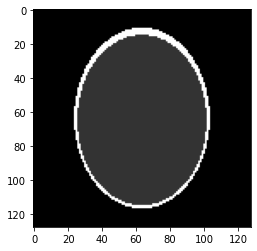

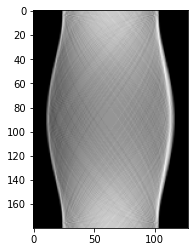

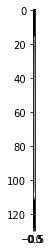

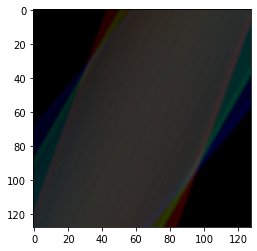

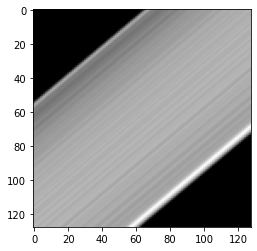

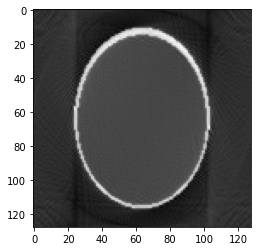

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.2619595, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [6]:
from radon import sino2multi

N = 10
M = 50

if IM_CH == 1:
    plt.gray()

plt.imshow(traintest_dataset[N]['gt'].numpy()[0,:,:])
plt.show()

plt.imshow(traintest_dataset[N]['sino'].numpy()[0,:,:])
plt.show()

plt.imshow(traintest_dataset[N]['sino'].numpy()[0,M,:,:])
plt.show()

plt.imshow(sino2multi(traintest_dataset[N]['sino'], (BATCH_SIZE, IM_HEIGHT, IM_WIDTH, IM_CH)).numpy()[0,:,:,M-30:M:10])
plt.show()

plt.imshow(sino2multi(traintest_dataset[N]['sino'], (BATCH_SIZE, IM_HEIGHT, IM_WIDTH, IM_CH)).numpy()[0,:,:,M])
plt.show()

plt.imshow(traintest_dataset[N]['rec'].numpy()[0,:,:])
plt.show()

print(
    tf.reduce_max(traintest_dataset[N]['gt']), 
    tf.reduce_max(traintest_dataset[N]['sino']), 
    tf.reduce_max(traintest_dataset[N]['rec']))

In [7]:
from train import Train

acad = Train(models)

Epoch  1 ; Loss:  0.35226822


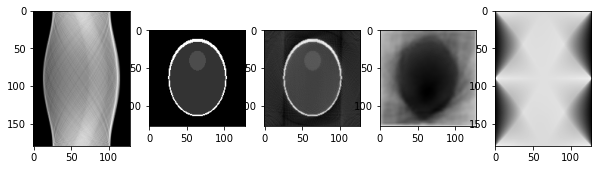

Epoch  2 ; Loss:  0.33330894


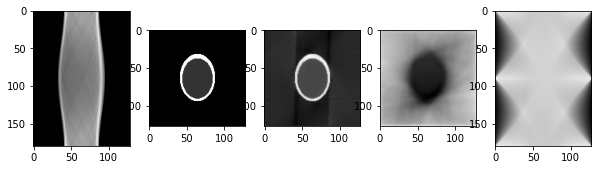

Epoch  3 ; Loss:  0.29341415


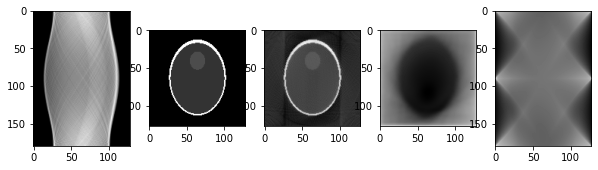

Epoch  4 ; Loss:  0.21784118


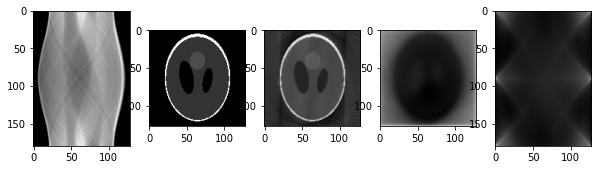

Epoch  5 ; Loss:  0.17545795


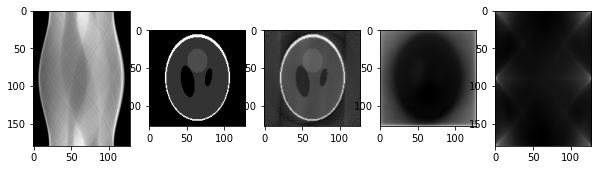

Epoch  6 ; Loss:  0.1736294


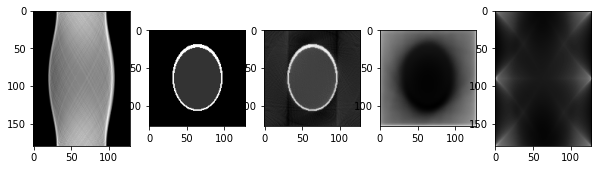

Epoch  7 ; Loss:  0.17246966


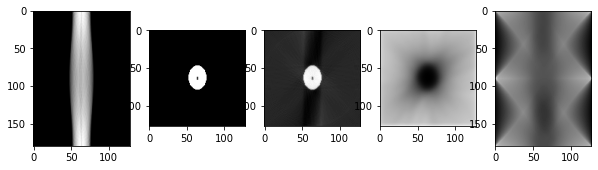

Epoch  8 ; Loss:  0.17136969


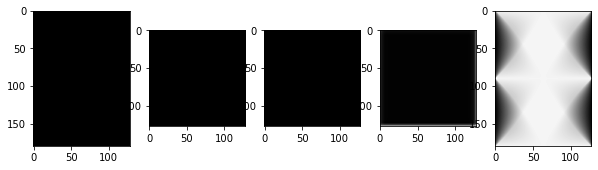

Epoch  9 ; Loss:  0.16998275


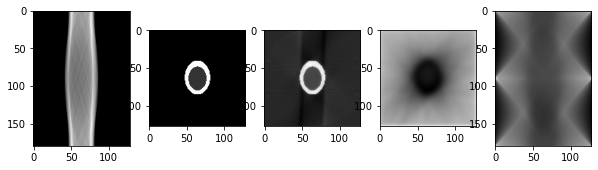

Epoch  10 ; Loss:  0.16827771


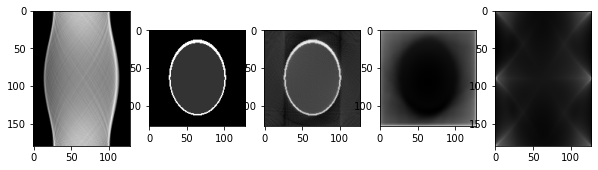

Epoch  11 ; Loss:  0.16631715


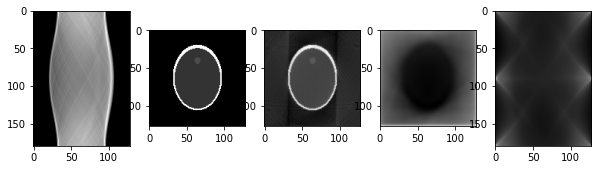

Epoch  12 ; Loss:  0.16377196


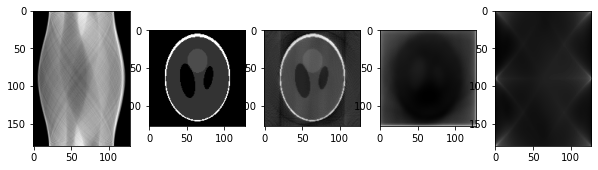

Epoch  13 ; Loss:  0.16088964


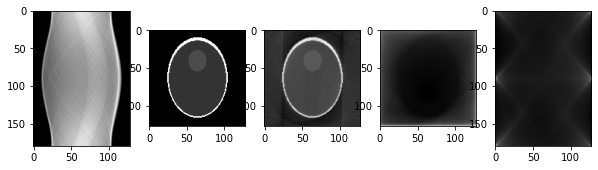

Epoch  14 ; Loss:  0.15751359


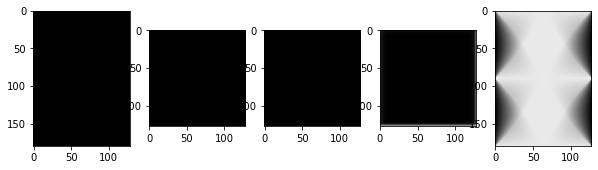

Epoch  15 ; Loss:  0.15330285


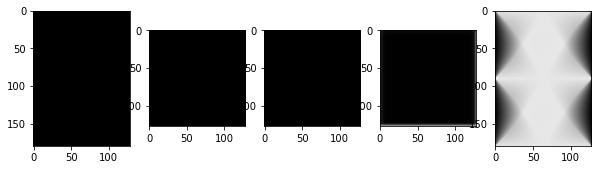

Epoch  16 ; Loss:  0.14842437


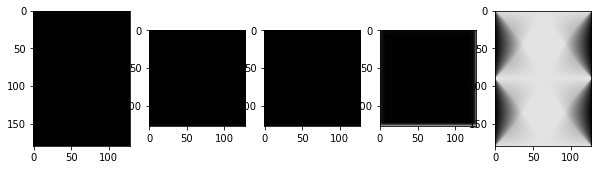

Epoch  17 ; Loss:  0.14257526


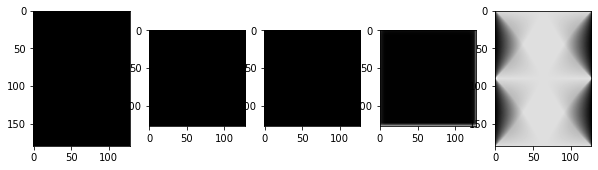

Epoch  18 ; Loss:  0.13614187


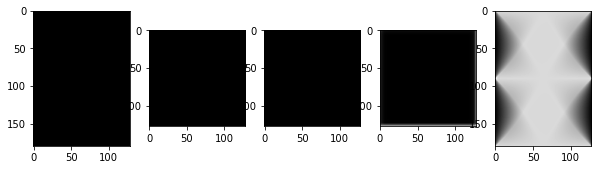

Epoch  19 ; Loss:  0.12877998


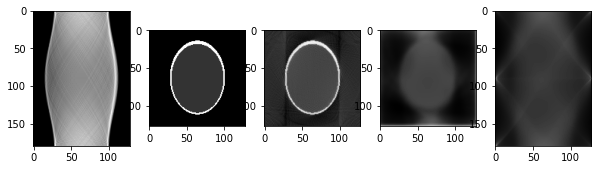

Epoch  20 ; Loss:  0.121554606


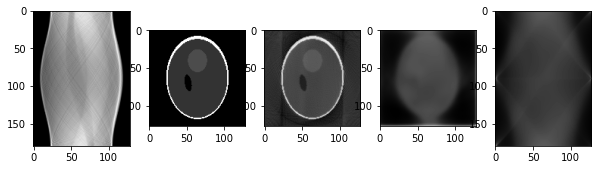

Epoch  21 ; Loss:  0.11401346


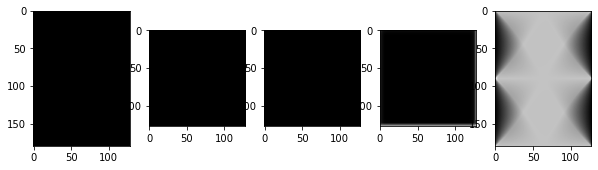

Epoch  22 ; Loss:  0.107069515


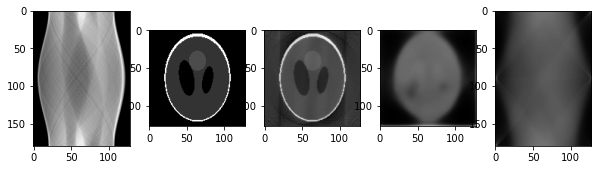

Epoch  23 ; Loss:  0.100725666


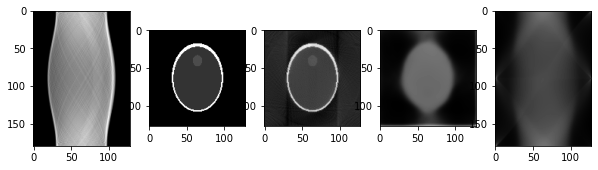

Epoch  24 ; Loss:  0.09464551


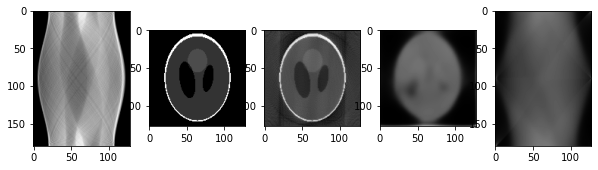

Epoch  25 ; Loss:  0.0891215


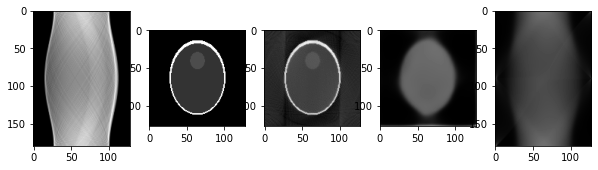

Epoch  26 ; Loss:  0.08338425


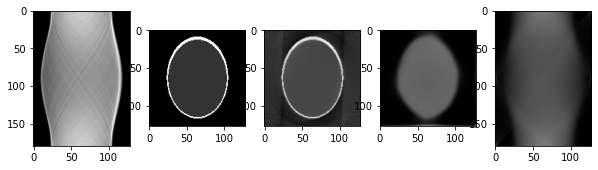

Epoch  27 ; Loss:  0.07705677


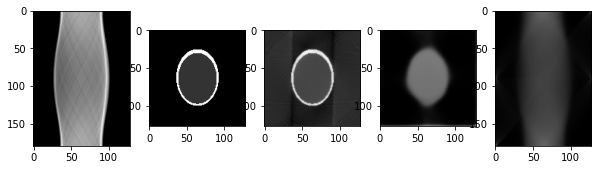

Epoch  28 ; Loss:  0.07069636


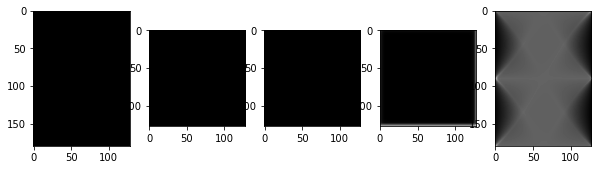

Epoch  29 ; Loss:  0.06385596


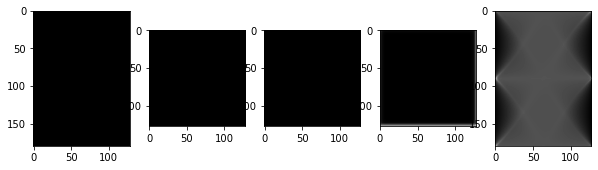

Epoch  30 ; Loss:  0.056711756


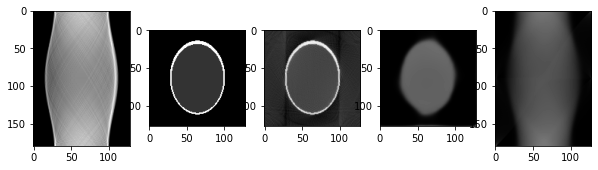

Epoch  31 ; Loss:  0.049795225


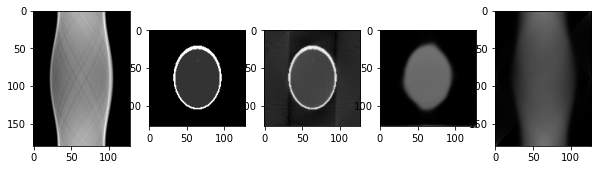

Epoch  32 ; Loss:  0.043545146


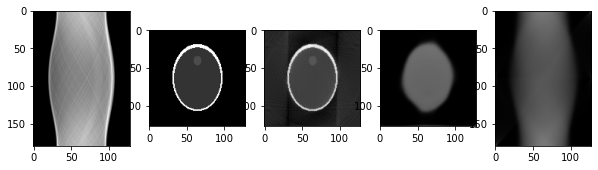

Epoch  33 ; Loss:  0.037752293


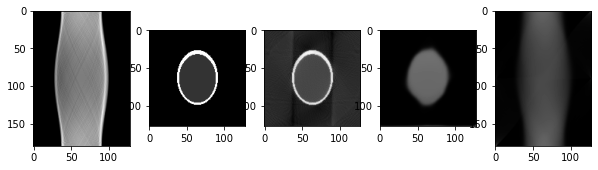

Epoch  34 ; Loss:  0.033274047


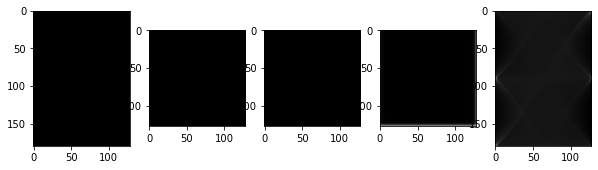

Epoch  35 ; Loss:  0.029824499


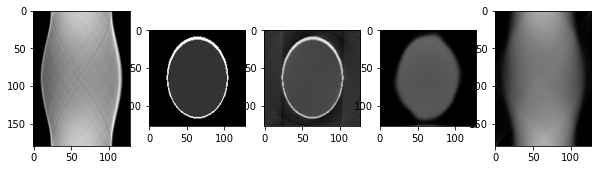

Epoch  36 ; Loss:  0.026933603


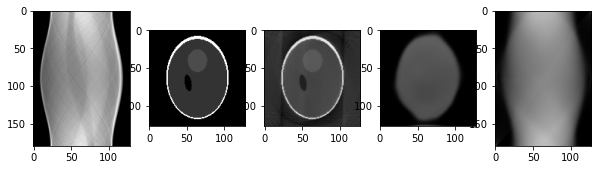

Epoch  37 ; Loss:  0.024932513


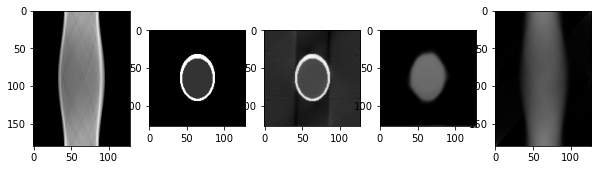

Epoch  38 ; Loss:  0.023367232


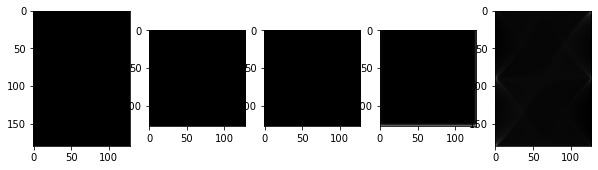

Epoch  39 ; Loss:  0.022014467


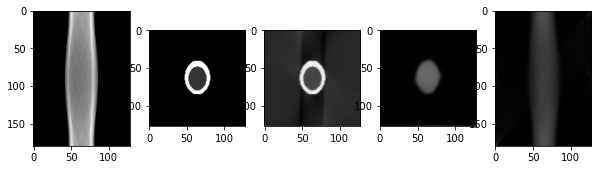

Epoch  40 ; Loss:  0.02109705


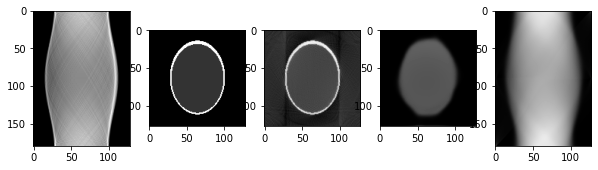

Epoch  41 ; Loss:  0.020401848


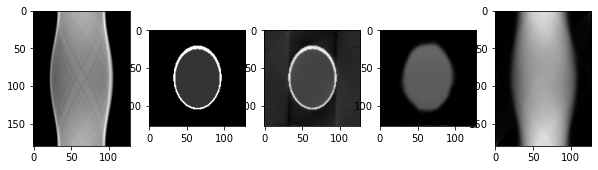

Epoch  42 ; Loss:  0.019750932


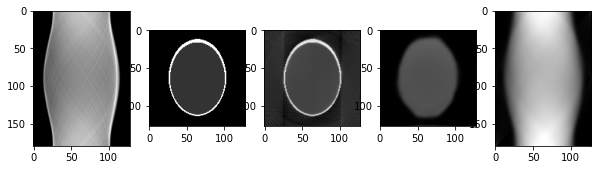

Epoch  43 ; Loss:  0.01941904


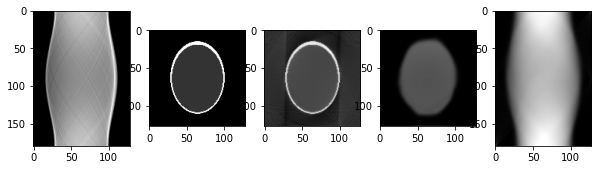

Epoch  44 ; Loss:  0.019116087


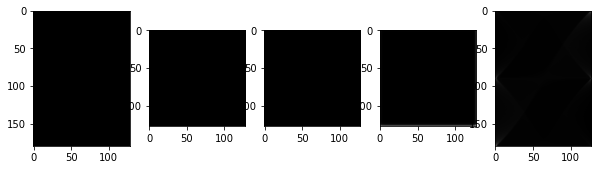

Epoch  45 ; Loss:  0.018644279


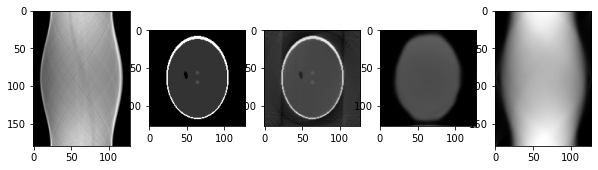

Epoch  46 ; Loss:  0.018531287


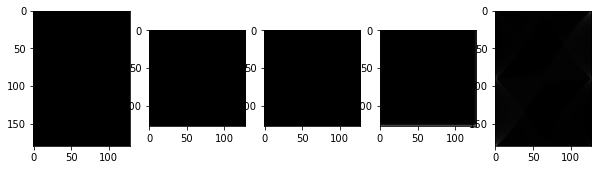

Epoch  47 ; Loss:  0.01821974


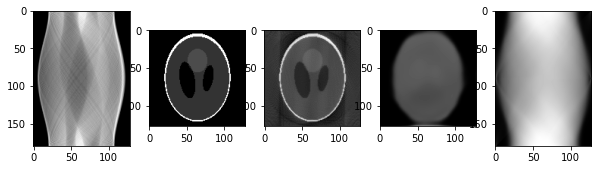

Epoch  48 ; Loss:  0.017965838


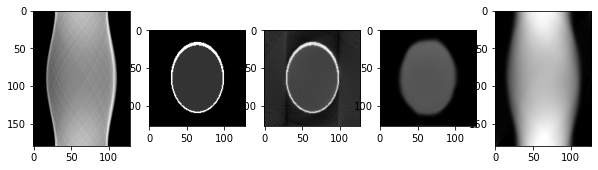

Epoch  49 ; Loss:  0.017762994


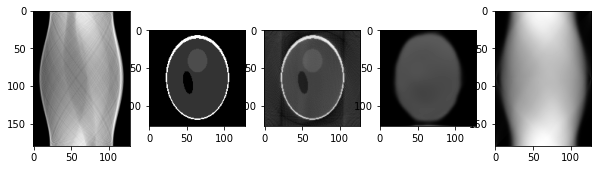

Epoch  50 ; Loss:  0.017716657


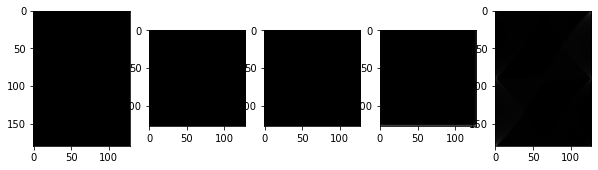

Epoch  51 ; Loss:  0.017488463


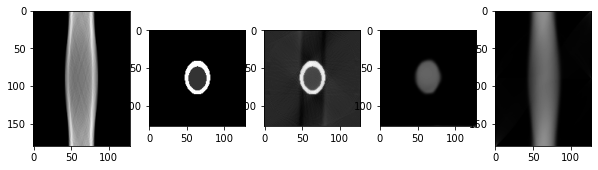

Epoch  52 ; Loss:  0.017471679


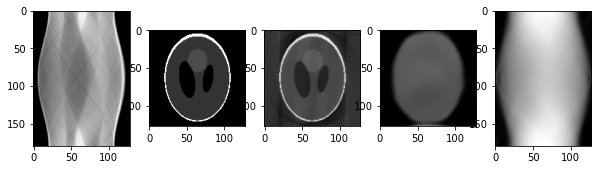

Epoch  53 ; Loss:  0.01730342


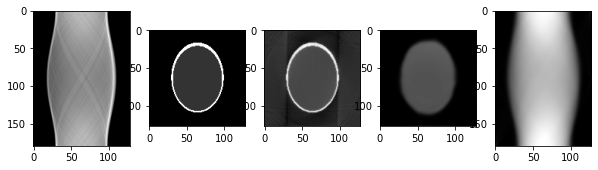

Epoch  54 ; Loss:  0.017234752


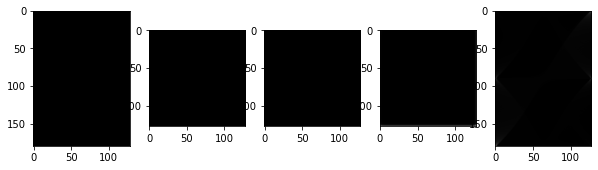

Epoch  55 ; Loss:  0.017143138


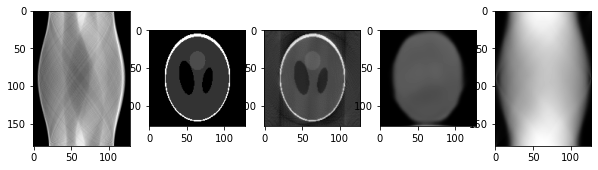

Epoch  56 ; Loss:  0.016992986


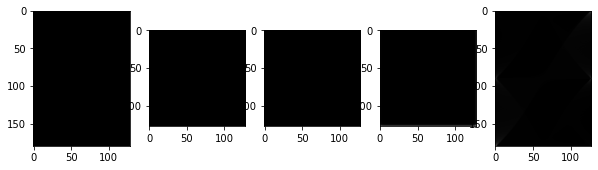

Epoch  57 ; Loss:  0.016929548


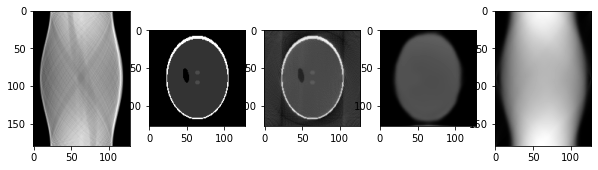

Epoch  58 ; Loss:  0.016917717


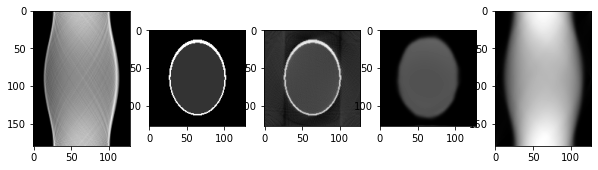

Epoch  59 ; Loss:  0.016808366


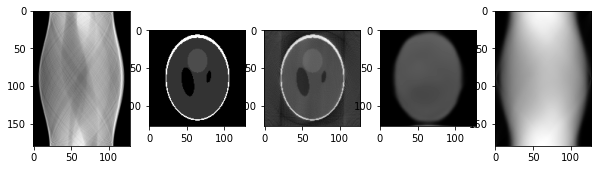

Epoch  60 ; Loss:  0.016708978


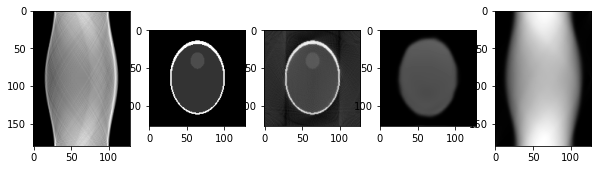

Epoch  61 ; Loss:  0.016684152


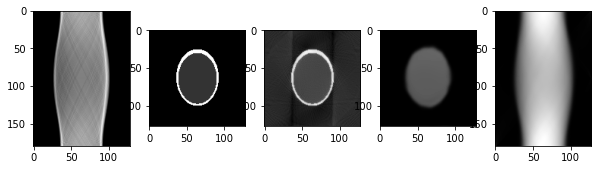

Epoch  62 ; Loss:  0.016664026


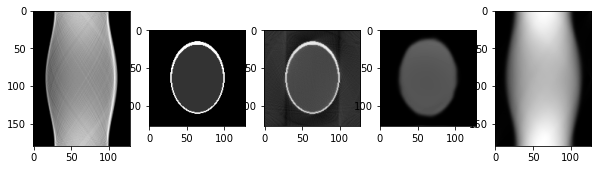

Epoch  63 ; Loss:  0.016561171


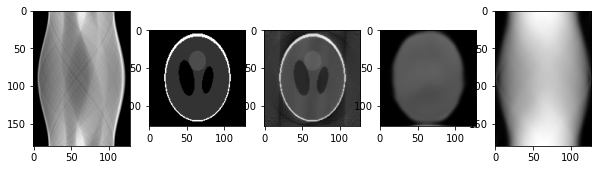

Epoch  64 ; Loss:  0.016681682


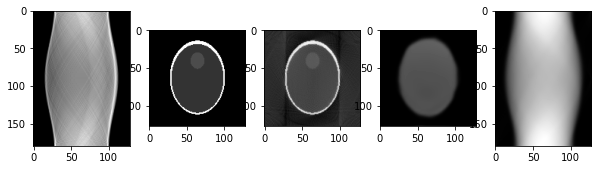

Epoch  65 ; Loss:  0.016456794


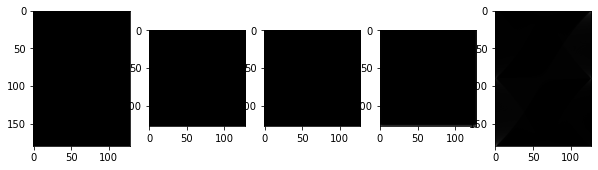

Epoch  66 ; Loss:  0.01645985


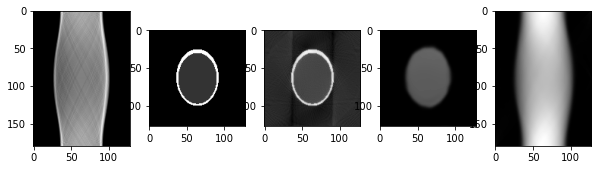

Epoch  67 ; Loss:  0.016458958


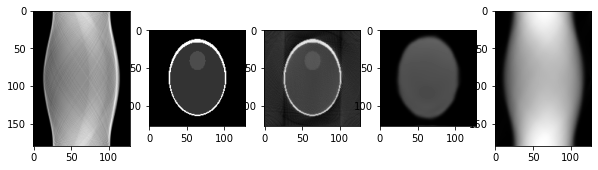

Epoch  68 ; Loss:  0.01642998


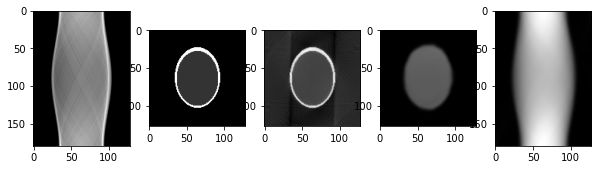

Epoch  69 ; Loss:  0.01640578


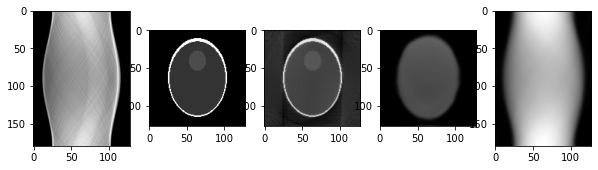

Epoch  70 ; Loss:  0.01630693


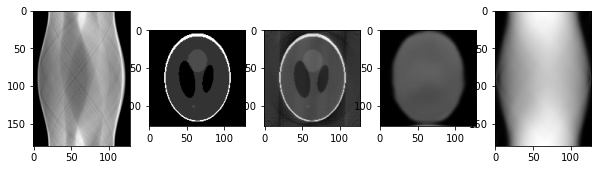

Epoch  71 ; Loss:  0.016287008


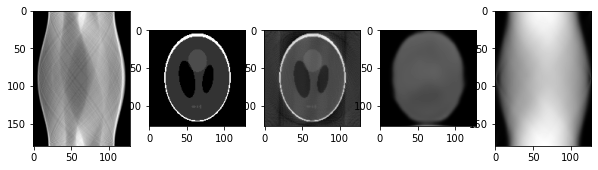

Epoch  72 ; Loss:  0.016455876


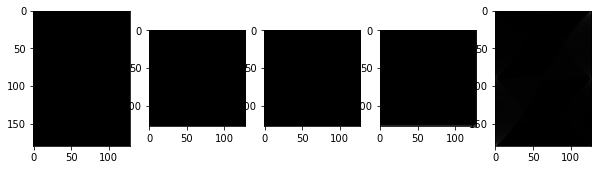

Epoch  73 ; Loss:  0.016322127


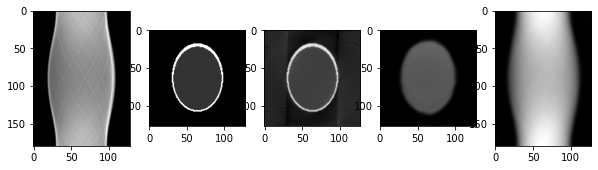

Epoch  74 ; Loss:  0.016275918


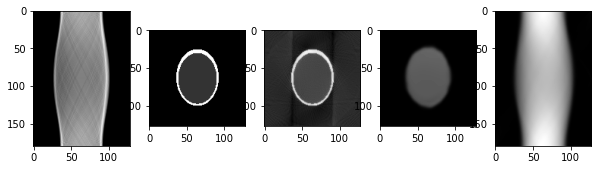

Epoch  75 ; Loss:  0.016362544


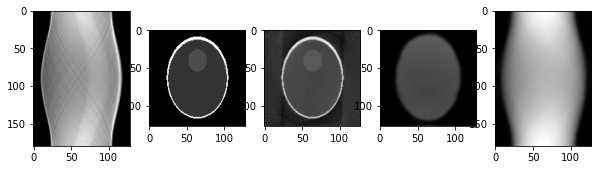

Epoch  76 ; Loss:  0.016171865


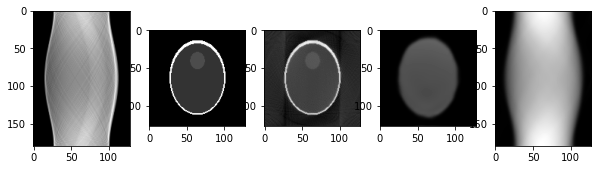

Epoch  77 ; Loss:  0.016066527


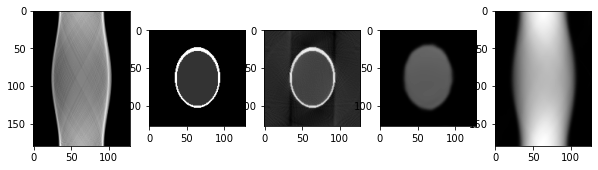

Epoch  78 ; Loss:  0.016091263


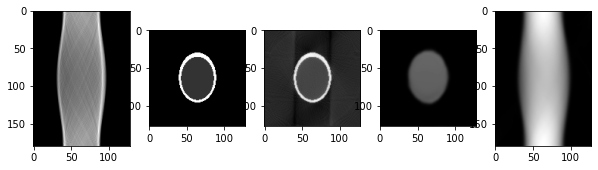

Epoch  79 ; Loss:  0.016196212


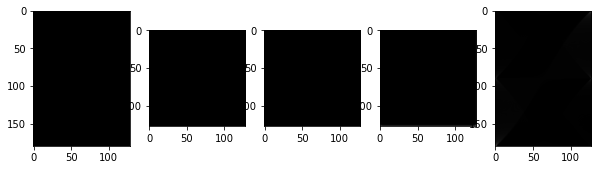

Epoch  80 ; Loss:  0.01604881


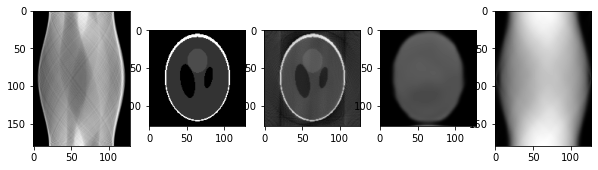

Epoch  81 ; Loss:  0.01602524


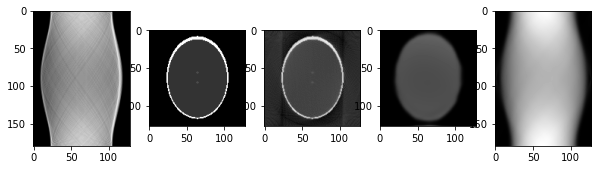

Epoch  82 ; Loss:  0.01599222


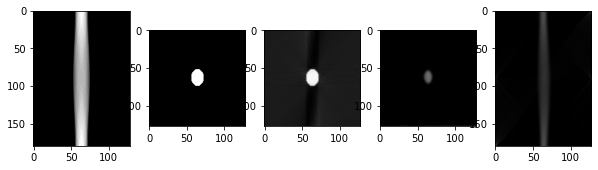

Epoch  83 ; Loss:  0.016004043


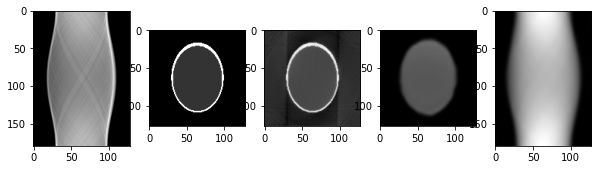

Epoch  84 ; Loss:  0.015917316


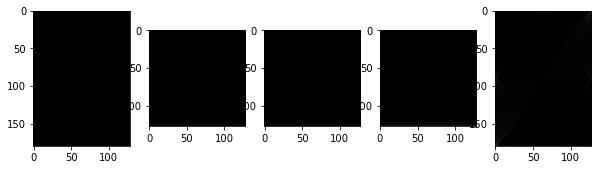

KeyboardInterrupt: 

In [8]:
acad.train(1000, traintest_dataset, (BATCH_SIZE, IM_HEIGHT, IM_WIDTH, IM_CH), lr = 1e-5)

In [ ]:
from utils import get_transform_mat, inverse_warp

TDN = 1

img = traintest_dataset[TDN]['frame1']
target_img = traintest_dataset[TDN]['frame2']
intrs = traintest_dataset[TDN]['input_intrinsics']

depth1 = depth_net(img)

enc1 = encoder_depth(img)[0]
enc2 = encoder_depth(target_img)[0]

ego = ego_net(tf.concat([enc1, enc2], -1))
        
img_with_extra_features = tf.concat([img, feature_net(img)], -1)
        
depth_for_input = 1 / depth1[0]
egomotion_mat_i_j = get_transform_mat(ego, 0, 1)
synth_image, synth_image_mask = (
    inverse_warp(
        img_with_extra_features,
        depth_for_input,
        egomotion_mat_i_j,
        intrs[:, 0, :, :],
        tf.linalg.inv(intrs[:, 0, :, :])
    )
)

synth_image *= synth_image_mask

plt.imshow(img[0,:,:,:])
plt.show()
plt.imshow(target_img[0,:,:,:])
plt.show()

for i in range(0, synth_image.shape[3]):
    fig=plt.figure(figsize=(10, 10))
    fig.add_subplot(1,2,1)
    plt.imshow(img_with_extra_features[0,:,:,i])
    
    fig.add_subplot(1,2,2)
    plt.imshow(synth_image[0,:,:,i])
    plt.show()

In [ ]:
from utils import get_transform_mat, inverse_warp

TDN = 6

img = traintest_dataset[TDN]['frame2']
target_img = traintest_dataset[TDN]['frame1']
intrs = traintest_dataset[TDN]['input_intrinsics']

depth1 = depth_net(img)

enc1 = encoder_depth(img)[0]
enc2 = encoder_depth(target_img)[0]

ego = ego_net(tf.concat([enc1, enc2], -1))
        
img_with_extra_features = feature_net(img)
        
depth_for_input = 1 / depth1[0]
egomotion_mat_i_j = get_transform_mat(ego, 0, 1)
synth_image, synth_image_mask = (
    inverse_warp(
        img_with_extra_features,
        depth_for_input,
        egomotion_mat_i_j,
        intrs[:, 0, :, :],
        tf.linalg.inv(intrs[:, 0, :, :])
    )
)

synth_image *= synth_image_mask

print(synth_image.shape)

fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1,3,1)
plt.imshow(img[0,:,:,:])
fig.add_subplot(1,3,2)
plt.imshow(target_img[0,:,:,:])
fig.add_subplot(1,3,3)
plt.imshow(refinement_net(synth_image)[0])
plt.show()

In [ ]:
plt.imshow(traintest_dataset[0]['frame1'][0])
plt.show()
plt.imshow(traintest_dataset[0]['frame2'][0])
plt.show()
plt.imshow(1/tf.squeeze(depth_net(traintest_dataset[0]['frame1'])[0][0]))
plt.show()
plt.imshow(1/tf.squeeze(depth_net(traintest_dataset[0]['frame2'])[0][0]))
plt.show()
plt.imshow(refinement_net(traintest_dataset[0]['frame1'])[0])
plt.show()

print(tf.reduce_max(refinement_net(traintest_dataset[0]['frame2'])[0]))
print(tf.reduce_min(refinement_net(traintest_dataset[0]['frame2'])[0]))

In [ ]:
import inference
from inference import inference
from PIL import Image
import numpy as np

traintest_dataset.switchMode('train')

TDN = 2

test_ego = ego_net(tf.concat([encoder_depth(traintest_dataset[TDN]['frame2'])[0], encoder_depth(traintest_dataset[TDN]['frame1'])[0]], -1))

print(test_ego)

plt.gray()

fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1,4,1)
plt.imshow(traintest_dataset[TDN]['frame2'][0])
#plt.show()
fig.add_subplot(1,4,2)
plt.imshow(traintest_dataset[TDN]['frame1'][0])
#plt.show()

nv = [0, traintest_dataset[TDN]['frame2']]

#for t in test_ego:

nv = inference(
    models, 
    traintest_dataset[TDN]['frame2'], 
    #nv[1],
    traintest_dataset[TDN]['input_intrinsics'], 
    #test_ego
    tf.stack([
        test_ego[0],
        #tf.constant([[20.15372334e-03,  9.41181206e-05, -39.48752709e-03, -3.90249588e-05, -40.06552975e-03, -3.79380908e-05]], tf.float32),
        #tf.constant([[ -0.01729971, 0.06628282, 0.02391691,  0.3364282,   0.08313861,  0.03378082 ]], tf.float32),
        tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], tf.float32),
        tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], tf.float32),
        tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], tf.float32)
    ], 1)
)

#fig=plt.figure(figsize=(10, 10))
#fig.add_subplot(1,2,1)
fig.add_subplot(1,4,3)
plt.imshow(nv[0][0][:,:,:3])
#plt.show()

#fig.add_subplot(1,2,2)
fig.add_subplot(1,4,4)
plt.imshow(nv[1][0])
plt.show()
# plt.imshow(nv[2][0])
# plt.show()
# plt.imshow(nv[3][0])
# plt.show()
# plt.imshow(nv[4][0])
# plt.show()
print(tf.cast(nv[1][0]*255, tf.int32).numpy().shape)
Image.fromarray(np.uint8(tf.cast(nv[1][0]*255, tf.int32).numpy())).save('./final.png')
Image.fromarray(np.uint8(tf.cast(traintest_dataset[TDN]['frame2'][0]*255, tf.int32).numpy())).save('./input.png')
Image.fromarray(np.uint8(tf.cast(traintest_dataset[TDN]['frame1'][0]*255, tf.int32).numpy())).save('./gt.png')
Image.fromarray(np.uint8(tf.cast(nv[0][0][:,:,:3]*255, tf.int32).numpy())).save('./sampling.png')

In [ ]:
## anim_images = []

TDN = 2
steps = 30

target_ego = tf.constant([[20.15372334e-03,  9.41181206e-05, -39.48752709e-03, -3.90249588e-05, -40.06552975e-03, -3.79380908e-05]], tf.float32) / 2
delta_ego = target_ego / steps
for i in range(steps):
    nv = inference(
        models, 
        traintest_dataset[TDN]['frame1'], 
        #nv[1],
        traintest_dataset[TDN]['input_intrinsics'], 
        #test_ego
        tf.stack([
            #test_ego[0],
            delta_ego*i,
            tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], tf.float32),
            tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], tf.float32),
            tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], tf.float32)
        ], 1)
    )
    
    anim_images.append(Image.fromarray(np.uint8(nv[1][0]*255)))

anim_images[0].save('./exp4.gif',
               save_all=True, append_images=anim_images[1:], optimize=False, duration=40, loop=1)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

In [ ]:
vi_gan.train(2000, traintest_dataset, lr = 1e-5,
    show_intermediate = False, 
    intermediate_delta = 5,
    use_target_for_vi_loss = False,
    weights_encdec = {
        'vi_loss': 1.0,
        'pixel_loss': 1.0,
        'per_loss': 1e-7,
        'ae_loss': 0.1,
        'cyc_loss': 0.1,
        'cyc_per_loss': 1e-7,
        'gen_loss_realfake': 0.01,
        'gen_loss_pose': 0.01,
        'gen_loss_inter_realfake': 0.01,
        'gen_loss_inter_pose': 0.01,
        'fader_gen_loss_pose': 0.0
    },
    weights_disc = {
        'disc_loss_realfake': 1.0,
        'disc_loss_pose': 1.0,
        'disc_loss_inter_realfake': 1.0,
        'disc_loss_inter_pose': 1.0,
        'fader_disc_loss_pose': 0.0
    })

In [ ]:
for name, m in models.items():
    if m:
        m.save_weights('./models/'+name+'_exp_7_1000epochs_room.h5')

In [ ]:
for name, m in models.items():
    if m and name != 'refinement_net':
        print('done', name)
        m.load_weights('./models/'+name+'_exp_1.h5')

In [ ]:
for name, m in models.items():
    if m:
        print('done', name)
        m.load_weights('./models/'+name+'_exp_6_1000epochs_room.h5')

In [ ]:
traintest_dataset.switchMode('test')
x = traintest_dataset[5]
plt.imshow(x['frame1'].numpy()[0,:,:,0])
plt.show()

plt.imshow(dec([enc([x['frame1'], x['attrs1']]), x['attrs1']]).numpy()[0,:,:,0])
plt.show()

print(x['attrs1'])

for i in range(int(x['attrs1'][0][0]), int(x['attrs1'][0][0])+20*15,1):
    test_attrs = angleNormPair(degreesToRadians(tf.cast([i], dtype=tf.float32)))
    #test_attrs = tf.cast([i], dtype=tf.float32)
    #test_attrs = (test_attrs + 1)/2
    test_attrs = tf.reshape(test_attrs, [1, 2])
    test_attrs = tf.tile(test_attrs, [BATCH_SIZE,1])

    plt.gray()
    plt.imshow(dec([enc([x['frame1'], x['attrs1']]), test_attrs]).numpy()[0,:,:,0])
    plt.show()

In [ ]:
from PIL import Image
import numpy as np

traintest_dataset.switchMode('test')
x = traintest_dataset[0]
plt.imshow(x['frame1'].numpy()[0,:,:,0])
plt.show()

plt.imshow(dec([enc([x['frame1'], x['attrs1']]), x['attrs1']]).numpy()[0,:,:,0])
plt.show()

print(x['attrs1'])

anim_images = []

for i in range(int(x['attrs1'][0][0]), int(x['attrs1'][0][0])+20*15,1):
    test_attrs = angleNormPair(degreesToRadians(tf.cast([i], dtype=tf.float32)))
    #test_attrs = tf.cast([i], dtype=tf.float32)
    #test_attrs = (test_attrs + 1)/2
    test_attrs = tf.reshape(test_attrs, [1, 2])
    test_attrs = tf.tile(test_attrs, [BATCH_SIZE,1])

    im = dec([enc([x['frame1'], x['attrs1']]), test_attrs]).numpy()[0,:,:,:]

    anim_images.append(Image.fromarray(np.uint8(im*255)).convert('P'))

    #plt.imshow(im)
    #plt.show()

anim_images[0].save('./anim_images/exp21_2.gif',
               save_all=True, append_images=anim_images[1:], optimize=False, duration=40, loop=1)

In [ ]:
from PIL import Image
import numpy as np

test_attrs = tf.cast([int(x['attrs1'][0][0])+10*6], dtype=tf.float32)
#test_attrs = (test_attrs + 1)/2
test_attrs = tf.reshape(test_attrs, [1, 1])
test_attrs = tf.tile(test_attrs, [BATCH_SIZE,1])
Image.fromarray((dec([enc([x['frame1'], x['attrs1']]), test_attrs]).numpy()[0,:,:,0]*255).astype(np.int8), mode='L').save('../test_images/exp7.png')

In [ ]:
import tensorflow as tf
import utils
from PIL import Image, ImageOps
import cv2 as cv
from random import shuffle
from glob import glob
import numpy as np

def custom_preprocess_image(im,h,w,chns):
    loadedim = im.resize((h,w))
    if chns == 1:
        loadedim = loadedim.convert('L')
        #loadedim = ImageOps.invert(loadedim)
    elif chns == 3:
        loadedim = loadedim.convert('RGB')
    im_frame = np.array(loadedim).reshape(h,w,chns)
    im_frame = tf.image.convert_image_dtype(im_frame, tf.float32)
    
    return im_frame

incat_imgs = glob('../3d_data_4/car/*')
incat_imgs.sort(key = lambda x: int(x.split('_r')[1].split('.')[0]))
incat_imgs = incat_imgs[::2]
for im in incat_imgs:
    im_frame = custom_preprocess_image(Image.open(im), IM_HEIGHT, IM_WIDTH, IM_CH)
    print(im)
    plt.imshow(im_frame.numpy()[:,:,0])
    plt.show()
    